# Model assessment

## Import data

In [1]:
import pandas as pd
import numpy as np

rr_df = pd.read_csv('../clean_data/ramen_features.csv')
rr_df.head()

,Stars,Bar,Bowl,Box,Can,Cup,Pack,Tray,2014,2015,2016,2017,2018,Five Year Consumption Increase,Spicy,Variety Length
0,3.75,0,0,0,0,1,0,0,0.123677,0.136813,0.146715,0.145021,0.143390,1,0,0.236559
1,1,0,0,0,0,0,1,0,0.015769,0.016576,0.019735,0.020791,0.020378,1,1,0.602151
2,2.25,0,0,0,0,1,0,0,0.096193,0.100693,0.106206,0.105749,0.109095,1,0,0.279570
3,2.75,0,0,0,0,0,1,0,0.015769,0.016576,0.019735,0.020791,0.020378,1,1,0.279570
4,3.75,0,0,0,0,0,1,0,0.120072,0.080406,0.110621,0.138860,0.150348,1,0,0.129032


## Imputation of unrated values

Our first attept will be to drop unrated values.  
Depending on our model evaluations we may revisit this step.  
(Note there is a total of 3 "Unrated" values in the dataset.  

In [2]:
rated_df = rr_df[~(rr_df.Stars == "Unrated")]

In [3]:
# Change column type to float
rated_df_with_types = rated_df.copy()
rated_df_with_types.Stars = rated_df_with_types.Stars.astype('float')

## Train, test and validation split

In [4]:
# Independant variables
X = rated_df_with_types.drop('Stars', axis=1)

# Dependant variable
y = rated_df_with_types.Stars

In [5]:
from sklearn.model_selection import train_test_split

# Split in train, test and validation (80%, 10%, 10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

## Setting a random seed

In [6]:
random_seed = 42

## Model evaluation utilities

In [7]:
import matplotlib.pyplot as plt

def plot_residuals(y, y_hat):
    residuals = (y-y_hat)
    plt.title("Predicted vs Residuals")
    plt.scatter(x=y_hat, y=residuals)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
import statsmodels.api as sm
import pylab as py

def plot_qq(y, y_hat):
    sm.qqplot((y-y_hat), line ='45') 
    py.show()

In [10]:
def eval(y, y_hat):
    mae = mean_absolute_error(y, y_hat)
    rmse = mean_squared_error(y, y_hat)**(1/2)
    r2 = r2_score(y, y_hat)
    return (mae, rmse, r2)

## Running models

As both of the models I've decided to use have no hyperparameter I will focus on calculating and comparing signals I obtain from the evaluation utilities.

### First model : EBM (Explainable boosting machines)

In [11]:
from interpret.glassbox import ExplainableBoostingRegressor

ebm = ExplainableBoostingRegressor(random_state=random_seed)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(binning_strategy='uniform', data_n_episodes=2000,
                             early_stopping_run_length=50,
                             early_stopping_tolerance=1e-05,
                             feature_names=['Bar', 'Bowl', 'Box', 'Can', 'Cup',
                                            'Pack', 'Tray', '2014', '2015',
                                            '2016', '2017', '2018',
                                            'Five Year Consumption Increase',
                                            'Spicy', 'Variety Length'],
                             feature_step_n_inner_bags=0,
                             feature_types=['categorical', 'categ...
                                            'categorical', 'categorical',
                                            'categorical', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
         

In [12]:
y_test_ebm_pred = ebm.predict(X_test)
y_val_ebm_pred = ebm.predict(X_val)

## Linear regression from scikit-learn

In [13]:
# Removing highly correlated variables (Let's only keep 2018)
col_subset = ['Bar', 'Bowl', 'Box', 'Can', 'Cup','Pack', 'Tray','Spicy', 'Variety Length', '2018']

X_train_linear = X_train[col_subset]
X_test_linear = X_test[col_subset]
X_val_linear = X_val[col_subset]

In [14]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(X_train_linear, y_train)

y_test_linear_pred = lm.predict(X_test_linear)
y_val_linear_pred = lm.predict(X_val_linear)

## Save models and datasets

In [103]:
from joblib import dump, load

dump(lm, '../models/linear.joblib')
dump(ebm,'../models/ebm.joblib')

linear_val_data = X_val_linear.copy()
ebm_val_data = X_val.copy()

linear_val_data['Stars'] = y_val
ebm_val_data['Stars'] = y_val

linear_val_data.to_csv('../clean_data/linear_val_data.csv', index=False)
ebm_val_data.to_csv('../clean_data/ebm_val_data.csv', index=False)

## Model evaluation and discussion

In [15]:
evals = []

# Append evaluation metrics per test/val sets and ebm/linear models
evals.append(eval(y_test, y_test_linear_pred))
evals.append(eval(y_val, y_val_linear_pred))
evals.append(eval(y_test, y_test_ebm_pred))
evals.append(eval(y_val, y_val_ebm_pred))

# Create and output dataframe
columns = ["mae", "rmse", "r2"]
evals_df = pd.DataFrame(evals, columns=columns)
evals_df.index = ["Test linear", "Val linear", "Test ebm", "Val ebm"]
evals_df

,mae,rmse,r2
Test linear,0.768447,1.055846,-0.014522
Val linear,0.693633,0.997686,0.003975
Test ebm,0.734396,1.004691,0.081402
Val ebm,0.668379,0.966107,0.066030


From this table we see that both models explain very little variance. In fact, the linear model does worse on the test set than predicting the average... In comparison the ebm's do a little better although a model explaining 8% of the variance isn't great for our use case. 

The mean absolute error is smaller than the root mean squared error, which indicates that there might large residuals caused by our predictions. 

Let's now take a look at the residuals.

### Residuals

#### Linear - test

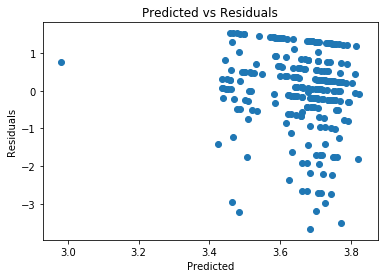

In [16]:
plot_residuals(y_test, y_test_linear_pred)

#### Linear - val

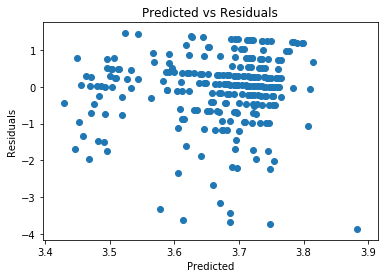

In [17]:
plot_residuals(y_val, y_val_linear_pred)

#### EBM - test

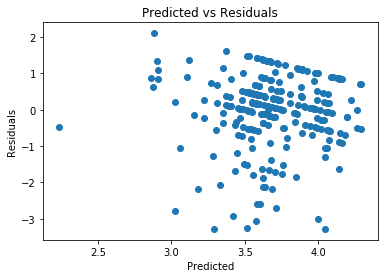

In [18]:
plot_residuals(y_test, y_test_ebm_pred)

#### EBM - val

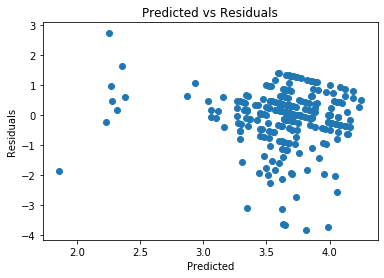

In [19]:
plot_residuals(y_val, y_val_ebm_pred)

From these we see that errors don't seem to be systematic in any way that could easily be fixed.
We should either test with other models or try to gather more / other features which could have a stronger relation to our target variable...


Let's now look at particularities of our models...

### Linear viable?

#### Assumption of independence

Altough ramen reviews were done by the same reviewer, we really have no way to garantee independence. Judging of the quality of ramen is very subjective. We can start with the assumptions that the ratings are independent.

#### Assumption of normality of residuals

Let's validate by looking at a q-q plot of the residuals.

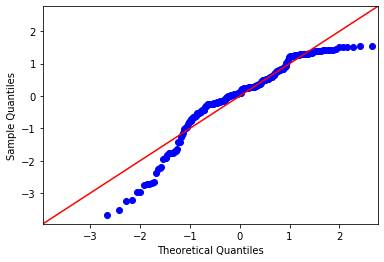

In [22]:
plot_qq(y_test, y_test_linear_pred)

This plot indicates that our residuals do not appear o follow a normal distribution. We should not trust the results of our model.

### EBMs

Let's take a look at EBM's built in explanation of its results.

In [23]:
from interpret import show

ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7096/120741405520/ -->

In [24]:
from interpret.perf import RegressionPerf

ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7096/120803254224/ -->

From those we see that the different feature variables explained very little of the variance of our dataset. Given this, it is not surprising to see that the predictions were so poor.

EBM can fit complex boundaries and were only able to obtain an $R^2$ of 8% of the variance. This is marginaly better than guessing in the context of our ramen ratings. Ideally we would have wanted a model which expressed results with a margin significant enough to simplify comparison of ramen products.

## Conclusion

Overall, I feel the EBMs did a better job at explaining the poor relationship between the result of their predictions and the target and feature variables. Looking at the linear coefficients was not particularly useful and the model ended up not satisfying the necessary assumptions.


I do not recommend using either of these models to guide the choice of a ramen product. Insead I would probably average the star rating by brand and use that as a proxy to make a decision next time you are in the grocery store.

Having had a bit more time I would have compared this later approach to the model's ranking.